<a href="https://colab.research.google.com/github/SusiGu/SemAI23/blob/main/GumS_V09_PGM.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

# Bayesian Networks in Python

In this tutorial, we will explore how to use Bayesian networks in Python using the `pgmpy` library.

See documentation at:
- https://pgmpy.org/
- https://pgmpy.org/models/bayesiannetwork.html
- https://pgmpy.org/factors/discrete.html
- https://pgmpy.org/exact_infer/ve.html

## Implementation in Python using `pgmpy`.

Let's start by installing the `pgmpy` library.

In [2]:
!pip install -q pgmpy networkx matplotlib plotly daft

     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 1.9/1.9 MB 25.3 MB/s eta 0:00:00


Import the required libraries.

In [3]:
import numpy as np
from pgmpy.models import BayesianNetwork
from pgmpy.factors.discrete import TabularCPD
import networkx as nx
import matplotlib.pyplot as plt

Create the Bayesian network:

+-------------------------+-----+
| PetersAlarmFails(True)  | 0.1 |
+-------------------------+-----+
| PetersAlarmFails(False) | 0.9 |
+-------------------------+-----+
+--------------------+------+
| TrainStrike(True)  | 0.05 |
+--------------------+------+
| TrainStrike(False) | 0.95 |
+--------------------+------+
+--------------------+-------------------+--------------------+
| TrainStrike        | TrainStrike(True) | TrainStrike(False) |
+--------------------+-------------------+--------------------+
| JohannaLate(True)  | 0.5               | 0.02               |
+--------------------+-------------------+--------------------+
| JohannaLate(False) | 0.5               | 0.98               |
+--------------------+-------------------+--------------------+
+------------------+-----+-------------------------+
| PetersAlarmFails | ... | PetersAlarmFails(False) |
+------------------+-----+-------------------------+
| TrainStrike      | ... | TrainStrike(False)      |
+------------------+

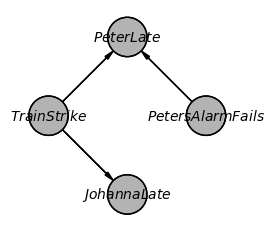

In [11]:
# Define the network structure
model = BayesianNetwork([
    ('PetersAlarmFails', 'PeterLate'),
    ('TrainStrike', 'PeterLate'),
    ('TrainStrike', 'JohannaLate')
    ])

statenames = {'TrainStrike': ['True', 'False'],
              'PeterLate': ['True', 'False'],
              'JohannaLate': ['True', 'False'],
              'PetersAlarmFails': ['True', 'False']}
model.to_daft().render()
# Define the probability distribution for 'Alarm'
cpd_PetersAlarmFails = TabularCPD(variable='PetersAlarmFails', variable_card=2,
                          state_names=statenames,
                          values=[[0.1], [0.90]])

# Define the probability distribution for 'TrainStrike'
cpd_TrainStrike = TabularCPD(variable='TrainStrike', variable_card=2,
                          state_names=statenames,
                          values=[[0.05], [0.95]])

# Define the conditional probability distribution for 'JohannaLate'
cpd_JohannaLate = TabularCPD(variable='JohannaLate', variable_card=2,
                      state_names=statenames,
                      evidence=['TrainStrike'], evidence_card=[2],
                      values=[[0.5, 0.02],
                              [0.5, 0.98]])

# Define the conditional probability distribution for 'PeterLate'
cpd_PeterLate = TabularCPD(variable='PeterLate', variable_card=2,
                      state_names=statenames,
                      evidence=['PetersAlarmFails', 'TrainStrike'],
                      evidence_card=[2, 2],
                      values=[[0.7, 0.4, 0.3, 0.01],
                              [0.3, 0.6, 0.7, 0.99]])



# Add the probability distributions to the model
model.add_cpds(cpd_PetersAlarmFails, cpd_TrainStrike, cpd_JohannaLate, cpd_PeterLate)

# Print
for cpd in model.get_cpds():
  print(cpd)



b) Wie hoch ist die Wahrscheinlichkeit, dass Johanna bzw Peter zu spät in die Arbeit kommen? => Johanna = 4% , Peter = 6%

In [13]:
from pgmpy.inference import VariableElimination
inference = VariableElimination(model)

print(inference.query(variables=['JohannaLate']))
print(inference.query(variables=['PeterLate']))

+--------------------+--------------------+
| JohannaLate        |   phi(JohannaLate) |
+====================+====================+
| JohannaLate(True)  |             0.0440 |
+--------------------+--------------------+
| JohannaLate(False) |             0.9560 |
+--------------------+--------------------+
+------------------+------------------+
| PeterLate        |   phi(PeterLate) |
+==================+==================+
| PeterLate(True)  |           0.0636 |
+------------------+------------------+
| PeterLate(False) |           0.9365 |
+------------------+------------------+


c) Wie hoch ist die Wahrscheinlichkeit, dass Johanna zu spät in die Arbeit kommt, falls Peters Wecker
nicht funktioniert? Johanna => 4%

In [15]:
evidence={'PetersAlarmFails':'True'}
result = inference.query(variables=['JohannaLate'], evidence=evidence)
print(evidence)
print(result)

{'PetersAlarmFails': 'True'}
+--------------------+--------------------+
| JohannaLate        |   phi(JohannaLate) |
+====================+====================+
| JohannaLate(True)  |             0.0440 |
+--------------------+--------------------+
| JohannaLate(False) |             0.9560 |
+--------------------+--------------------+


d) Wie hoch ist die Wahrscheinlichkeit, dass Johanna zu spät in die Arbeit kommt, wenn Peter zu spät
in die Arbeit kommt? Johanna => 15%

In [16]:
evidence={'PeterLate':'True'}
result = inference.query(variables=['JohannaLate'], evidence=evidence)
print(evidence)
print(result)

{'PeterLate': 'True'}
+--------------------+--------------------+
| JohannaLate        |   phi(JohannaLate) |
+====================+====================+
| JohannaLate(True)  |             0.1484 |
+--------------------+--------------------+
| JohannaLate(False) |             0.8516 |
+--------------------+--------------------+



e) Wie hoch ist die Wahrscheinlichkeit, dass Johanna zu spät in die Arbeit kommt, wenn Peter zu
spät in die Arbeit kommt obwohl Peters Wecker funktioniert? Johanna => 31%

In [17]:
evidence={'PeterLate':'True', 'PetersAlarmFails': 'False'}
result = inference.query(variables=['JohannaLate'], evidence=evidence)
print(evidence)
print(result)

{'PeterLate': 'True', 'PetersAlarmFails': 'False'}
+--------------------+--------------------+
| JohannaLate        |   phi(JohannaLate) |
+====================+====================+
| JohannaLate(True)  |             0.3139 |
+--------------------+--------------------+
| JohannaLate(False) |             0.6861 |
+--------------------+--------------------+
